# Simple 1d pendulum

Consider the system

$$\theta'' = -a \sin(\theta)$$
with $\theta(0)=1$ and $\theta'(0)=0$.

We'll generate fake data (using $a=9.81$), and then learn the parameter $a$ via:

1. Maximum likelihood
2. Exact Bayesian inference using quadrature
3. MCMC
4. The VAE, which requires us to be able to differentiate the model output. We'll do this using a forward sensitivity approach, and check the derivatives numerically.



We'll see that the multi-modal nature of the log-likelihood mean that this is a difficult problem. 

If you run the notebook yourself, note that it is interesting to change the number of data points, the time range, and the noise level (sigma), all of which affect how difficult inference is for this problem.



In [1]:
import jax.numpy as jnp
from jax import grad, jit, random, vmap, jit
import numpy as np
from scipy.integrate import odeint
from functools import partial
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches #used to write custom legends
%matplotlib inline

Let's start by simulating some fake data. We'll use $a=9.81$ as the true parameter value. 

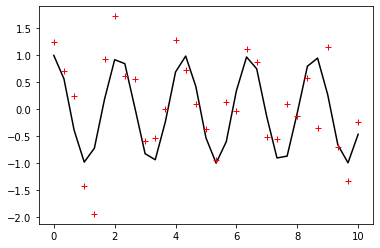

In [2]:
def pendulum(x, t, a):
    """Time derivative of the Pendulum.
    Args:
       x (array size 2): [theta, dtheta/dt]
       a (float): Parameters.
        Return: dx/dt (array size 2)
    """
    return np.array([x[1], -a*np.sin(x[0])])

# lets simulate some fake data
times = np.linspace(0,10, 31)
x0=[1.,0.]
true_traj = odeint(partial(pendulum, a=9.81), y0=x0,t=times)

sigma=0.5 # noise variance
sigma2 =sigma**2
data = true_traj[:,0]+np.random.normal(0.,sigma,true_traj.shape[0] )

plt.plot(times, true_traj[:,0],'k-')
plt.plot(times, data,'r+')

In [3]:
def negloglike(a, data, times):
    '''
    Returns the negative log likelihood (up to proportionality) for a given parameter a. 
    Note that the constants due to sigma2 have not been included, so this can't be used to infer sigma.
    
    '''
    # given a value of a, solve the ODE, compute the sum of square errors
    mod = partial(pendulum, a=a)
    out = odeint(mod, y0=[1.,0.],t=times)
    return(np.sum((out[:,0]-data)**2)/(2*sigma2))

# objective(9.81, true_traj[:,0], times), objective(9.81, data, times)

The log-likelihood is multi-modal, thus optimization routines may struggle with the multiple minima. For example, if we simply use the scipy optimizer, we find the right answer some, but not all, of the time.


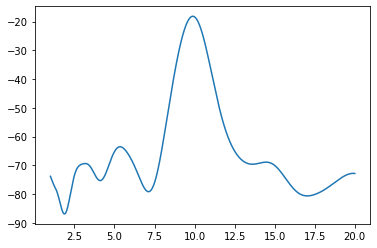

In [4]:
avals = np.linspace(1,20.,1001)
negloglikes = np.array([negloglike(a, data, times) for a in avals])


plt.plot(avals, -negloglikes)

In [5]:
from scipy.optimize import minimize_scalar

res = minimize_scalar(partial(negloglike, data=data,times=times), bounds=[1,20], method='bounded')

print('Maximum likelihod estimate of a =', res.x)

Maximum likelihod estimate of a = 9.887544552805494


Add asymptotic confidence interval for MLE? Laplace approximation?

## Bayesian inference

Consider the prior $a\sim U[1,20]$. For this 1d example, the posterior can then easily be computed via quadrature:



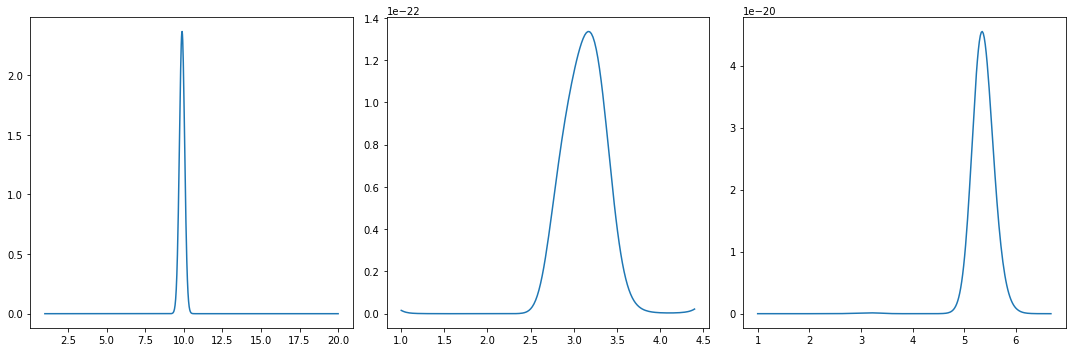

In [28]:
unnorm = np.exp(-negloglikes)
da = avals[1]-avals[0]

post = unnorm/(da*np.sum(unnorm))
fig, ax = plt.subplots(1, 3, figsize=(15,5))
ax[0].plot(avals, post)

ax[1].plot(avals[:180], post[:180])
ax[2].plot(avals[:300], post[:300])




plt.tight_layout()



#plt.plot(avals, post)
#plt.xlim((5,15))



The plot on the left is the posterior plotted over the full prior range. Note that although the loglikelihood has multiple modes, the posterior appears uni-modal. However, if we only look at small interval of the x-axis (as an MCMC sampler, or any optimization routine may end up doing) then we can see the other peaks are still there, they are just not visible once we plot the main peak. 

The middle plot is the posterior when we only look at the range $[1,5]$. The right hand plot for the range $a \in [0,7]$. Note that the peak at 3 is no longer visible in this plot.

Let's now do MCMC. We'll use a random walk sampler. We'll see that depending upon the starting point and step-size, we may end up finding perfectly the posterior distribution, or, we may end up just finding one of these minor peaks instead.

In [7]:
def MCMC(a0, stepsize, niter):
    out = np.zeros(niter+1)
    ll = np.zeros(niter+1)
    out[0]=a0

    ll[0] = -negloglike(a0, data, times)
    acc=0

    for ii in range(niter):
        aprop = out[ii]+np.random.normal(0,stepsize, 1)
        if 1<aprop<20:
            llnew = -negloglike(aprop[0], data, times)
            logmh = llnew - ll[ii]
            #print(aprop, llnew, mh)
            if np.log(np.random.uniform(0.,1.,1))< logmh:
                #print('Accept')
                out[ii+1]=aprop
                ll[ii+1]=llnew
                acc += 1 
            else:
                out[ii+1]=out[ii]
                ll[ii+1]=ll[ii]
        else:
            out[ii+1]=out[ii]
            ll[ii+1]=ll[ii]
    
    print('Acceptance rate = ', acc/niter*100, '%')
    return(out,ll)

In [29]:
a_mcmc1, ll_mcmc1 = MCMC(12, 0.5, 5000)
a_mcmc2, ll_mcmc2 = MCMC(4, 0.5, 5000)

Acceptance rate =  37.580000000000005 %
Acceptance rate =  44.12 %


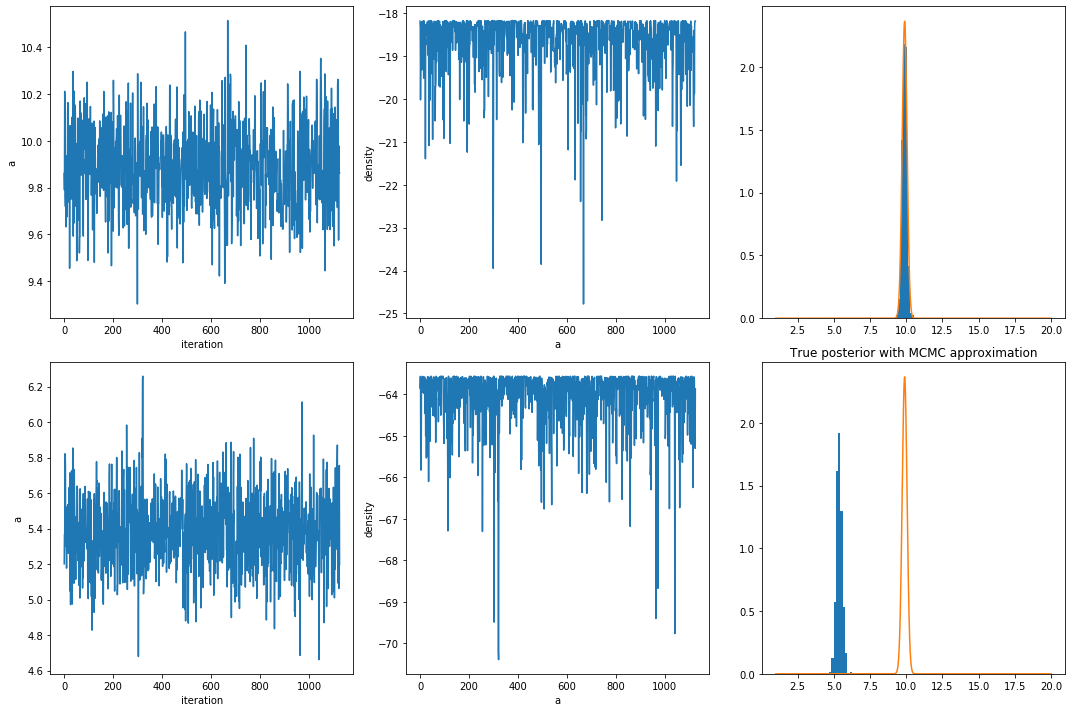

In [30]:
burnin=1000
thinby=4
fig, ax = plt.subplots(2, 3, figsize=(15,10))
ax[0][0].set(xlabel='iteration', ylabel='a')
ax[0][1].set(xlabel='iteration', ylabel='unnormalised log-likelihood')
ax[0][1].set(xlabel='a', ylabel='density')
ax[0][0].plot(a_mcmc1[500::thinby])
ax[0][1].plot(ll_mcmc1[500::thinby])
#ax[2].xlim((9.,11.))


ax[0][2].hist(a_mcmc1[500::thinby], density=True)
ax[0][2].plot(avals, post)
plt.title('True posterior with MCMC approximation')


ax[1][0].set(xlabel='iteration', ylabel='a')
ax[1][1].set(xlabel='iteration', ylabel='unnormalised log-likelihood')
ax[1][1].set(xlabel='a', ylabel='density')
ax[1][0].plot(a_mcmc2[500::thinby])
ax[1][1].plot(ll_mcmc2[500::thinby])
#ax[2].xlim((9.,11.))


ax[1][2].hist(a_mcmc2[500::thinby], density=True)
ax[1][2].plot(avals, post)
plt.title('True posterior with MCMC approximation')



plt.tight_layout()


Where we start the MCMC from determines which mode we find. The trace plots for both chains look good - in each case it would be tempting to conclude we had found a good approximation to the posterior.

But note that we typically only find the mode nearest to where we start the chains from. In 1-dimensional problems, we can probably spot this, but in higher dimensions, we may never realise there is a problem.

## Variational inference using the VAE


VI aims to find the distribution closest to the posterior according to the Kullback-Leibler divergence
$$q^*(\theta) = \arg \min_q KL(q(\theta) || p(\theta | D))$$
We usually restrict $q$ to lie in some parametric family of distributions, ie, $q=q_\phi$, and then find
$$\phi^* = \arg \min_\phi KL(q_\phi(\theta) || p(\theta | D))$$
We will use a Gaussian approximation
$$q_\phi(\theta) = \mathcal{N}(\theta; \mu, \tau^2) \quad \mbox{ where } \quad \phi=(\mu, \log\tau^2).$$


We can't compute this directly, but by noting that

\begin{align*}
KL(q_\phi(\theta) || p(\theta | D)) &= \mathbb{E}_{\theta \sim q} (\log q(\theta) - \log p(\theta | D))\\
&= \mathbb{E}_{\theta \sim q} \log q(\theta) - \mathbb{E}_{\theta \sim q} \log p(\theta, D) + \log p(D)
\end{align*}

we can see that minimizing the KL is equivalent to maximizing 
\begin{equation}
\mathcal{L}(\phi) = \mathbb{E}_{\theta \sim q} \log p(\theta, D) - \mathbb{E}_{\theta \sim q} \log q_\phi(\theta)
\end{equation}
where all expectations are with respect to $\theta \sim q_\phi(\theta)$. $\mathcal{L}$ is called the evidence lower bound (ELBO). 


An equivalent expression that will be useful is 
\begin{equation}
\mathcal{L} = \mathbb{E}_{\theta \sim q} \log p(D|\theta) - KL(q(\theta)|| p(\theta))
\end{equation}
ie, the ELBO is a trade-off between minimizing the expected log-likelihood of the data under $q$ whilst not moving too far from the prior distribution $p(\theta)$. It is a balance between fitting the data, and taking account of the prior.

For ease of computation, we'll change our prior for theta to  $p(\theta) = N(10,3^2)$. For two Gaussian distributions it is easy to show
$$KL(N(\mu_1, \sigma^2_1)|| N(\mu_2, \sigma^2_2)) = -\frac{1}{2}\log \frac{\sigma_1^2}{\sigma_2^2}+\frac{\sigma_1^2+(\mu_1-\mu_2)^2}{2\sigma_2^2}-\frac{1}{2}$$


To maximize $\mathcal{L}$ we'll want to compute its derivative wrt the variational parameters $\phi$. 
We'll use the VAE framework by Kingma et al. and approximate the expectation with a Monte Carlo sum

$$\mathbb{E}_{\theta\sim q(\mu, \tau^2)} \log p(D|\theta) \approx \frac{1}{S}\sum_{s=1} \log p(D \mid \mu+\tau e_s)
$$
where $e_s \sim N(0,1)$. Note that we've used the reparameterization trick, so that the random terms in the Monte Carlo sum come from a paramater-free distribution.


In [10]:
class VAE():
    def __init__(self, data, times, sigma2, S=50, phi0=np.array((1.,1.))):
        self.data = data
        self.times = times
        self.phi=phi0
        self.sigma2= sigma2
        #self.mu = 1. # starting point - make random?
        #self.logvar = 1. # starting point - make random
        #self.var=np.exp(self.logvar) # is it daft storing all of these?
        #self.sd = np.exp(self.logvar/2.)
        self.S=S  # may want to make the loss a function of S - not the model class so we can vary it.
        self.encoder(phi0)
        
    def encoder(self, phi):
        '''
        Encoder converts phi to the natural parameters for the variational approximation.
    
        '''
        self.phi=phi
        self.mu = phi[0] 
        self.var = np.exp(phi[1])
        self.sd = np.sqrt(self.var)
        return(None)
    
    
    def print(self):
        print('mu=', self.mu, 'tau^2=',self.var, 'tau=',self.sd)
          
    def reparam(self, e):
        '''Reparametrization trick - converts a random N(0,1) into theta'''
        return(self.mu + e[:,None]*self.sd)

    def decoder(self, a):
        ''' 
        Gives the model prediction theta(t,a) give parameter a
        '''
        return(odeint(partial(pendulum, a=a), y0=[1.,0.],t=self.times)[:,0]) 
    
    def loglike(self, theta):
        '''
        Given parameter theta, it calls the decoder to do the simulation, and returns the log-likelihood.
        '''
        return(-0.5*np.sum((self.data-self.decoder(theta[0]))**2)/self.sigma2)  
      
    
    def loss(self, phi, rng=None):
        '''
        Given variational parameter phi it
        - calls the encoder to convert phi to natural parameters
        - computes the KLD between prior and variational approximation
        - computes a Monte Carlo approximation to the expected log likelihood
        - returns the negative ELBO
        '''
        self.encoder(phi)
        kld = -0.5* np.log(self.var/9.)+(self.var+(self.mu-10.)**2)/(2*9)-0.5
        if rng is not None:
            np.random.seed(rng)
        esamples=np.random.normal(0., 1., self.S)
        thetasamples = self.reparam(esamples)
        out = [self.loglike(theta) for theta in thetasamples]
        Eloglike = np.mean(out)
        return(kld-Eloglike)






As a somewhat naive first step, lets simply maximize $\mathcal{L}$ using a grid search over possible values. Given we given we only have two variational parameters this isn't too expensive. 

In [11]:
model = VAE(data, times, sigma2, S=40)
muvals = np.linspace(5,15,40)
tau2vals = np.logspace(-2,0,20)
mugrid, logtau2grid = np.meshgrid(muvals, np.log(tau2vals))
mugrid_flat = mugrid.flatten()
logtau2grid_flat = logtau2grid.flatten()

out = np.zeros(mugrid_flat.size)

for ii in range(mugrid_flat.size):
    phi=np.array((mugrid_flat[ii], logtau2grid_flat[ii]))
    out[ii] = model.loss(phi)

Let's compare the optimal values found (i.e., the mean and variance of the $\mathcal{N}(\theta; \mu, \tau^2)$ approximation to the true posterior) with the mean and variance of the approximation found from the MCMC. Note that they are in close agreement. Plotting the contour surface of the ELBO helps us to see how smooth (or otherwise) it looks.

9.871794871794872 0.03359818286283781
(9.888562604470422, 0.031969220674460355)


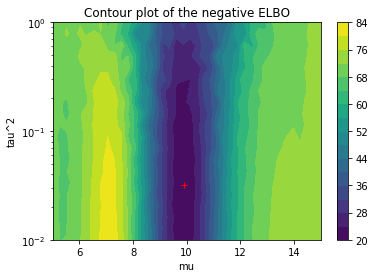

In [12]:
print(mugrid_flat[np.argmin(out)], np.exp(logtau2grid_flat[np.argmin(out)]))
print((np.mean(a_mcmc1),np.var(a_mcmc1)))
fig,ax=plt.subplots(1,1)
cp = ax.contourf(mugrid, np.exp(logtau2grid), out.reshape((20,40)), levels=15)
fig.colorbar(cp) # Add a colorbar to a plot
plt.yscale('log')
#plt.
plt.xlabel('mu')
plt.ylabel('tau^2')
plt.title('Contour plot of the negative ELBO')
plt.plot(np.mean(a_mcmc1),np.var(a_mcmc1), 'r+')

So we can see there is clear information about $\mu$, but less information about $\tau^2$. Note again though that when viewed from this scale, local variation is hidden. If we only look at the range $\mu \in [1,5]$, we will again see a local maxima at $\mu=3$. An optimizer may get stuck in this region. 

In [13]:
model = VAE(data, times, sigma2, S=20)
muvals = np.linspace(1,5,20)
tau2vals = np.logspace(-2,-0.5,20)
mugrid, logtau2grid = np.meshgrid(muvals, np.log(tau2vals))
mugrid_flat = mugrid.flatten()
logtau2grid_flat = logtau2grid.flatten()

out2 = np.zeros(mugrid_flat.size)

for ii in range(mugrid_flat.size):
    phi=np.array((mugrid_flat[ii], logtau2grid_flat[ii]))
    out2[ii] = model.loss(phi)
    

5.0 0.03569698846826065
(9.888562604470422, 0.031969220674460355)


Text(0.5, 1.0, 'Contour plot of the negative ELBO')

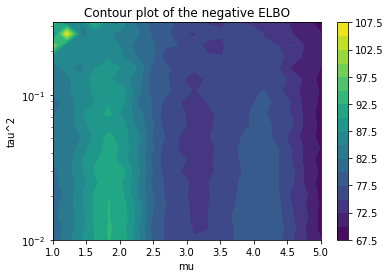

In [14]:
    
print(mugrid_flat[np.argmin(out2)], np.exp(logtau2grid_flat[np.argmin(out2)]))
print((np.mean(a_mcmc1),np.var(a_mcmc1)))
fig,ax=plt.subplots(1,1)
cp = ax.contourf(mugrid, np.exp(logtau2grid), out2.reshape((20,20)), levels=15)
fig.colorbar(cp) # Add a colorbar to a plot
plt.yscale('log')
#plt.
plt.xlabel('mu')
plt.ylabel('tau^2')
plt.title('Contour plot of the negative ELBO')
#plt.plot(np.mean(a_mcmc1),np.var(a_mcmc1), 'r+')

 ### Forward sensitivity
 
In general, we won't be able to do a grid search like this. So let's instead compute the gradient of $\mathcal{L}$ wrt $\phi=(\mu,\log\tau^2)$. We'll do this with the forward sensitivity approach. 



Let \begin{align*}
s(t;a)&=\frac{dz}{da}\\
\left(\begin{array}{c}s_1\\s_2\end{array}\right) &= \left(\begin{array}{c}\frac{dz_1}{da}\\\frac{dz_2}{da}\end{array}\right).\end{align*}

The forward-sensitivity approach works by deriving a differential equation for $s(t)$:

\begin{align*}
\frac{ds}{dt}(t,a)&=\frac{d}{dt}\frac{dz}{da}\\
&=\frac{d}{da}\frac{dz}{dt} \mbox{ by Clairaut's theorem}\\
&=\frac{d}{da} f(z;a)\\
&= \sum_i \frac{\partial f}{\partial z_i}\frac{d z_i}{da}+\frac{\partial f}{\partial a} \mbox{ by  the chain rule}\\
&= \sum_i\frac{\partial f}{\partial z_i} s_i +\frac{\partial f}{\partial a}
\end{align*}

In particular, for the pendulum system, we have

\begin{align*}
\frac{\partial f}{\partial a} &= \left(\begin{array}{c}0\\ -\sin(z_1)\end{array}\right)\\
\frac{\partial f}{\partial z_1}&=\left(\begin{array}{c}0\\ -a \cos(z_1)\end{array}\right)\\
\frac{\partial f}{\partial z_2}&=\left(\begin{array}{c}1\\ 0\end{array}\right)
\end{align*} 

Putting this together, we have the four dimensional ODE  given by 
$$\frac{d}{dt}\left(\begin{array}{c}z_1\\z_2\\s_1 \\s_2\end{array}\right) = \left(\begin{array}{c}z_2\\ -a\sin(z_1)\\ 
s_2\\
-a\cos(z_1) s_1 - \sin(z_1)
\end{array}\right)$$
with initial conditions $z_1(0)=1, z_2(0)=0, s_1(0)=0, s_2(0)=0$.



In [15]:
def pendulum_fwdsens(x, t, a):
    """Time derivative of the Pendulum and the sensitivities
    Args:
       x (array size 4): [theta, dtheta/dt, s1, s2]
       a (float): Parameters.
        Return: dx/dt (array size 2)
    """
    return np.array([x[1], -a*np.sin(x[0]), x[3], -a*np.cos(x[0])*x[2]-np.sin(x[0])])


#x0_fwdsens=[1.,0., 0., 0.]
#tmp = odeint(partial(pendulum_fwdsens, a=9.81), y0=x0_fwdsens,t=times)



The term term of difficulty in the ELBO is 
$$\log p(D|a) \propto -\frac{1}{2\sigma^2} \sum (D_i - \theta(t_i;a))^2$$
which has derivative

$$\frac{d \log p(D|a)}{d a} = \frac{1}{\sigma^2} \sum_i (D_i-\theta(t_i;a))\frac{d \theta(t_i; a)}{d a}$$



In [16]:
class VAE_fwdsens(VAE):
    
        
    def dloglike(self, theta):
        x0_fwdsens=[1.,0., 0., 0.]
        tmp = odeint(partial(pendulum_fwdsens, a=theta[0]), y0=x0_fwdsens,t=times)
        return(np.sum((self.data-tmp[:,0])* tmp[:,2])/self.sigma2)


As a check, we can compare with the numerical estimate of the derivative of the log-likelihood:

In [17]:
a=np.array(10)[None]
eps = 10**-5

model = VAE_fwdsens(data, times, sigma2, S=20)

print('These should agree')
print(model.dloglike(a))

print((model.loglike(a+eps)-model.loglike(a-eps))/(2.*eps))



These should agree
-4.009393548469409
-4.009598280063642




But we want the derivative of $\log p(D|a=\mu+\tau e)$ wrt $\phi = (\mu, \tau^2)$. That's easy enough

$$\frac{d \log p(D|a=\mu+\tau e)}{d\phi} = \frac{d \log p(D|a)}{da}\frac{da}{d\phi}$$

$$\frac{d \log p(D|a=\mu+\tau e)}{d\phi} = \frac{d \log p(D|a)}{da}\left(\begin{array}{c}1\\
\frac{exp(\phi_1/2) e}{2}
\end{array}
\right)$$



So we find that 
\begin{align*}
\nabla_\phi \left(\frac{1}{S}\sum_{s=1} p(D \mid \mu+\tau e_s) \right)&= \frac{1}{S}\sum_{s=1}^S \frac{d \log p(D\mid a_s)}{da_s}\left(\begin{array}{c} 1\\ \frac{exp(\phi_1/2) e_s}{2}\end{array}\right)\\
&= \frac{1}{\sigma^2 S}\sum_{s=1}^S \left(\begin{array}{c} 1\\ \frac{exp(\phi_1/2) e_s}{2}\end{array}\right)\sum_i (D_i-\theta(t_i;a_s))\frac{d \theta(t_i; a_s)}{d a_s}
\end{align*}




where $a_s=\mu+\tau e_s=\phi_0 + \exp(\phi_1/2) e_s$

In [18]:
class VAE_fwdsens(VAE):
    
    def decoder_fwdsens(self, theta):
        ''' 
        run the augmented fwd sensitivity ODEs
        Returns a T x 4 matrix. First column is theta(t), third column is dtheta/dt.
        '''
        x0_fwdsens=[1.,0., 0., 0.]
        return(odeint(partial(pendulum_fwdsens, a=theta[0]), y0=x0_fwdsens,t=times))      
    
    def loglike_and_grad(self, theta=None, fwdsens_traj=None):
        '''
        Returns dlog p(D|a)/da
        '''
        if fwdsens_traj is None:
            fwdsens_traj = self.decoder_fwdsens(theta)
        ll = -0.5*np.sum((self.data-fwdsens_traj[:,0])**2)/self.sigma2
        grad = np.sum((self.data-fwdsens_traj[:,0])* fwdsens_traj[:,2])/self.sigma2
        
        return((ll,grad))
    
    
    def Eloglike(self, phi=None, rng=None):
        ''' just for  checking purposes '''
        if phi is not None: # This is here so that if we call model.Eloglike_and_grad then phi gets updated.
            self.encoder(phi)
        
        if rng is not None:
            np.random.seed(rng)

        esamples=np.random.normal(0., 1., self.S)
        thetasamples = self.reparam(esamples)
        out = [self.loglike(theta) for theta in thetasamples]
        Eloglike = np.mean(out)
        return(Eloglike)
    
   
    def KL(self, phi=None):
        '''
        Computes KL divergence between N(phi) and N(10,3^2) distribution.
        '''
        if phi is not None: # This is here so that if we call model.Eloglike_and_grad then phi gets updated.
            self.encoder(phi)
            
        kld = -0.5* np.log(self.var/9.)+(self.var+(self.mu-10.)**2)/(2*9)-0.5
        return(kld)
    
    def dKL_dphi(self, phi=None):
        '''
        Computes KL divergence between N(phi) and N(10,3^2) distribution.
        '''
        if phi is not None: # This is here so that if we call model.Eloglike_and_grad then phi gets updated.
            self.encoder(phi)
        dkld = ((self.mu-10.)/9., -1./2.+np.exp(self.phi[1])/18.)
        
        return(dkld)
    
    
    def loss_and_grad(self, phi, rng=None):
        self.encoder(phi) 
        kld = self.KL()
        dkld = self.dKL_dphi()
        ell, dell = self.Eloglike_and_grad(rng=rng)
        loss = kld-ell
        dloss = np.array(dkld)-np.array(dell)
        return((loss, dloss))
        
    def Eloglike_and_grad(self, phi=None, rng=None):
        '''
        Returns an approximation to E_{a ~q} \log p(D|a) and its derivative wrt \phi        
        '''
        if phi is not None:   # This is here so that if we call model.Eloglike_and_grad then phi gets updated.
            self.encoder(phi)
        if rng is not None:
            np.random.seed(rng)
            
        esamples=np.random.normal(0., 1., self.S)
        thetasamples = self.reparam(esamples)
        
        ll_da = np.array([self.loglike_and_grad(theta) for theta in thetasamples])
        Eloglike = np.mean(ll_da[:,0])
        #print(ll_da[:,1][:,None])
        #print(esamples)
        #print(self.dtheta_dphi(esamples))
        tmp =np.multiply(ll_da[:,1][:, None],  self.dtheta_dphi(esamples))
        
        #dEloglike = (np.mean(ll_da[:,1]), np.mean(ll_da[:,1]*esamples)/(2.*np.sqrt(self.var)) )
        #return(np.array(ll_da))
        return(Eloglike, np.mean(tmp,axis=0))

   
    def dtheta_dphi(self, esamples):
        '''
        returns the p x 2p matrix dtheta/dphi
        '''
        da_dphi0 = np.zeros(esamples.size)+1.
        da_dphi1 = np.exp(self.phi[1]/2.)*esamples/2.
        return(np.array((da_dphi0, da_dphi1)).T)
    
 

In [19]:
print('Checking the gradients') 
model = VAE_fwdsens(data, times, sigma2, S=40)

a=np.array(10)[None]
eps = 10**-5
print('---------------------')

print('loglike and dloglike/da - should approximately agree')
print(model.loglike(a), (model.loglike(a+eps)-model.loglike(a-eps))/(2.*eps))
print(model.loglike_and_grad(a))

phi=(10.,0.2)

Ell, dEll = model.Eloglike_and_grad(phi, rng=2)
#print(Ell)

#
print('---------------------')
print('Eloglike - should  approximately agree ')
print(Ell)
print(model.Eloglike(phi, rng=2))
print('---------------------')

print('dEloglike/dphi - should approximately agree')
print(dEll)

eps1=np.zeros(2)
eps1[0]=eps
eps2=np.zeros(2)
eps2[1]=eps

phi+eps1
print((model.Eloglike(phi=phi+eps1, rng=2)-model.Eloglike(phi=phi-eps1, rng=2))/(2*eps),
     (model.Eloglike(phi=phi+eps2, rng=2)-model.Eloglike(phi=phi-eps2, rng=2))/(2*eps))
print('---------------------')


print('d KL/dphi - should agree exactly')
print(model.dKL_dphi(phi))
print((model.KL(phi=phi+eps1)-model.KL(phi=phi-eps1))/(2*eps),
     (model.KL(phi=phi+eps2)-model.KL(phi=phi-eps2))/(2*eps))

print('---------------------')
print('loss, and dloss/dphi - should approximately agree')
print(model.loss(phi, rng=2), 
     (model.loss(phi=phi+eps1, rng=2)-model.loss(phi=phi-eps1, rng=2))/(2*eps),
     (model.loss(phi=phi+eps2, rng=2)-model.loss(phi=phi-eps2, rng=2))/(2*eps))
     
print(model.loss_and_grad(phi, rng=2))




Checking the gradients
---------------------
loglike and dloglike/da - should approximately agree
-18.39194640965165 -4.009598280063642
(-18.391945146903357, -4.009393548469409)
---------------------
Eloglike - should  approximately agree 
-33.04405845369766
-33.04406040625603
---------------------
dEloglike/dphi - should approximately agree
[ 4.9046264  -9.48173678]
4.902274255513817 -9.481784927700687
---------------------
d KL/dphi - should agree exactly
(0.0, -0.4321442912133239)
0.0 -0.4321442912180728
---------------------
loss, and dloss/dphi - should approximately agree
33.610528403710816 -4.902274255513817 9.049640636504819
(33.610526451152445, array([-4.9046264 ,  9.04959249]))


Now we've checked the gradients, let's try optimizing.

In [20]:

phi=np.array((8.,1.)) # starting value of phi

model = VAE_fwdsens(data, times, sigma2, S=40, phi0=phi)

loss=-1000
dloss=1000

learning_rate=0.01

while dloss >10**-2:
    loss_new, dloss = model.loss_and_grad(phi)
    print(dloss)
    phinew = phi - learning_rate*dloss
    print('phi=',phinew)

    phi=phinew
    model.encoder(phi)
    dloss = np.abs(loss_new-loss)
    loss=loss_new
    print('loss=',loss, ', change in objective=', dloss)
    print('--------')
    

[-13.15801658   0.23990241]
phi= [8.13158017 0.99760098]
loss= 55.88821716002375 , change in objective= 1055.8882171600237
--------
[-7.22730359  1.49723635]
phi= [8.2038532  0.98262861]
loss= 54.60407446288017 , change in objective= 1.2841426971435794
--------
[-10.90446124  -0.11232532]
phi= [8.31289781 0.98375187]
loss= 48.44969312984958 , change in objective= 6.154381333030592
--------
[-9.46457989 -0.66491039]
phi= [8.40754361 0.99040097]
loss= 45.7486270893449 , change in objective= 2.701066040504678
--------
[-8.84407905  0.75657553]
phi= [8.4959844  0.98283521]
loss= 51.97052042102983 , change in objective= 6.221893331684932
--------
[-14.84033548   1.68445838]
phi= [8.64438776 0.96599063]
loss= 54.19676094833014 , change in objective= 2.2262405273003054
--------
[-8.39978099  1.15727909]
phi= [8.72838557 0.95441784]
loss= 53.15573621987645 , change in objective= 1.041024728453685
--------
[-7.33119876  3.63654922]
phi= [8.80169756 0.91805235]
loss= 41.81001572187343 , change i

[2.86999605 1.54243261]
phi= [ 9.85118069 -1.85870438]
loss= 21.83987579741575 , change in objective= 0.78661867813112
--------
[-1.69768534  1.94673254]
phi= [ 9.86815755 -1.87817171]
loss= 22.292774863946573 , change in objective= 0.4528990665308221
--------
[2.09515054 2.39621924]
phi= [ 9.84720604 -1.9021339 ]
loss= 22.98720076271409 , change in objective= 0.6944258987675163
--------
[0.81065883 2.31488497]
phi= [ 9.83909945 -1.92528275]
loss= 22.72027862048392 , change in objective= 0.2669221422301682
--------
[-3.00016897  1.45956068]
phi= [ 9.86910114 -1.93987836]
loss= 21.87395561434301 , change in objective= 0.8463230061409099
--------
[-1.56789755  2.49723699]
phi= [ 9.88478012 -1.96485073]
loss= 22.92241925020851 , change in objective= 1.0484636358654988
--------
[0.11281888 2.52846126]
phi= [ 9.88365193 -1.99013534]
loss= 23.03092012930894 , change in objective= 0.10850087910042916
--------
[-0.08505251  2.03624005]
phi= [ 9.88450245 -2.01049774]
loss= 22.480123681287747 , 

In [21]:
model.print()
print("MCMC estimates of posterior mean and variance ", np.mean(a_mcmc1),np.var(a_mcmc1), )

mu= 9.935432307125899 tau^2= 0.10186661588010014 tau= 0.31916549920080667
MCMC estimates of posterior mean and variance  9.888562604470422 0.031969220674460355


So we are finding a sensible looking posterior approximation. The variance is a bit large, but I think this is due to our stopping rule. We know the ELBO surface is quite flat as a function of $\phi_1$, so I think we're just stopping before we reach the maxima.

I haven't played around with the optimization yet. Its sensitive to the learning rate, S, and the stopping criterion.   


Note that, as before, where we start the optimization from determines which mode we find.



In [22]:

phi=np.array((2.,1.)) # starting value of phi

model = VAE_fwdsens(data, times, sigma2, S=40, phi0=phi)

loss=-1000
dloss=1000

learning_rate=0.01

while dloss >10**-2:
    loss_new, dloss = model.loss_and_grad(phi)
    print(dloss)
    phinew = phi - learning_rate*dloss
    print('phi=',phinew)

    phi=phinew
    model.encoder(phi)
    dloss = np.abs(loss_new-loss)
    loss=loss_new
    print('loss=',loss, ', change in objective=', dloss)
    print('--------')
    

[-108.50368384  106.69810361]
phi= [ 3.08503684 -0.06698104]
loss= 161.52183136802236 , change in objective= 1161.5218313680223
--------
[-4.20891896 -1.40684235]
phi= [ 3.12712603 -0.05291261]
loss= 77.22104013090006 , change in objective= 84.3007912371223
--------
[-6.3070899   0.78154178]
phi= [ 3.19019693 -0.06072803]
loss= 77.03544661399366 , change in objective= 0.18559351690640824
--------
[-2.70241216 -0.04454224]
phi= [ 3.21722105 -0.06028261]
loss= 77.18133911951396 , change in objective= 0.1458925055203082
--------
[-4.31065691  1.5163308 ]
phi= [ 3.26032762 -0.07544592]
loss= 75.87563843101326 , change in objective= 1.305700688500707
--------
[-5.06519168 -0.75800744]
phi= [ 3.31097953 -0.06786584]
loss= 76.96082003412398 , change in objective= 1.0851816031107262
--------
[-4.19307888  1.20664731]
phi= [ 3.35291032 -0.07993231]
loss= 76.27773959685422 , change in objective= 0.6830804372697656
--------
[-5.32107809  0.70509278]
phi= [ 3.4061211  -0.08698324]
loss= 75.5594342

[-2.69844049  1.06803379]
phi= [ 5.0251775  -0.18088909]
loss= 71.8305200013314 , change in objective= 0.6643430061440796
--------
[-0.76301477  0.86802455]
phi= [ 5.03280765 -0.18956933]
loss= 70.5470349384812 , change in objective= 1.2834850628501897
--------
[-2.3266965   1.27644412]
phi= [ 5.05607462 -0.20233377]
loss= 70.31131872100615 , change in objective= 0.23571621747505844
--------
[-2.72935727  0.76258538]
phi= [ 5.08336819 -0.20995963]
loss= 71.96115334272963 , change in objective= 1.6498346217234854
--------
[-2.4327528  -0.59076921]
phi= [ 5.10769572 -0.20405194]
loss= 70.85801763770867 , change in objective= 1.1031357050209607
--------
[-0.26751418  0.40614994]
phi= [ 5.11037086 -0.20811344]
loss= 71.81691188852596 , change in objective= 0.9588942508172948
--------
[1.46547855 0.59043526]
phi= [ 5.09571607 -0.21401779]
loss= 70.91139205634661 , change in objective= 0.9055198321793512
--------
[-3.84463575  1.70799971]
phi= [ 5.13416243 -0.23109779]
loss= 70.7107598067124

In [23]:
model.print()
print("MCMC estimates of posterior mean and variance ", np.mean(a_mcmc1),np.var(a_mcmc1), )

mu= 5.411129373149091 tau^2= 0.38272222381852816 tau= 0.6186454750651039
MCMC estimates of posterior mean and variance  9.888562604470422 0.031969220674460355


So we've found a different mode which isn't the true optima.


# IGNORE FROM HERE DOWN

First an attempt to use jax to derive the adjoint equations.

In [24]:
from jax import jacrev, jacfwd

def pendulum_jax(x, t, a):
    """Time derivative of the Pendulum.
    Args:
       x (array size 2): [theta, dtheta/dt]
       a (float): Parameters.
        Return: dx/dt (array size 2)
    """
    return(jnp.array([x[1], -a*jnp.sin(x[0])]))


The forward-sensitivity approach works by deriving a differential equation for $s(t)$:

\begin{align*}
\frac{ds}{dt}(t,a)&=\frac{d}{dt}\frac{dz}{da}\\
&=\frac{d}{da}\frac{dz}{dt} \mbox{ by Clairaut's theorem}\\
&=\frac{d}{da} f(z;a)\\
&= \sum_i \frac{\partial f}{\partial z_i}\frac{d z_i}{da}+\frac{\partial f}{\partial a} \mbox{ by  the chain rule}\\
&= \sum_i\frac{\partial f}{\partial z_i} s_i +\frac{\partial f}{\partial a}
\end{align*}


In [25]:
@jit
def pendulum_jax(x, t, a):
    """Time derivative of the Pendulum.
    Args:
       x (array size 2): [theta, dtheta/dt]
       a (float): Parameters.
        Return: dx/dt (array size 2)
    """
    return(jnp.array([x[1], -a*jnp.sin(x[0])]))

da = jit(jacfwd(pendulum_jax, argnums=2)) # gives df/da a 1 x 2 array
dx = jit(jacfwd(pendulum_jax, argnums=0)) # gives df/dx with ij th element df_j/dx_i

#da((1.,2.), 2., 9.81)
#dx((2.,1.), 2., 9.81)

@jit
def pendulum_fwdsens_jax(x,t,a):
    ''' Dim x = 4, output dim is 4.'''
    out = dx(x[0:2], t, a)
    #print(out)
    return(jnp.concatenate((pendulum_jax(x,t,a), out[0]*x[2]+out[1]*x[3]+da(x[0:2],t,a))))

%timeit pendulum_fwdsens_jax((2.,4., 1.,3.), 10., 2.81)
%timeit pendulum_fwdsens((2.,4., 1., 3.), 1., 2.81)


/Users/pmzrdw/opt/anaconda3/lib/python3.7/site-packages/jax/lib/xla_bridge.py:122: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


168 µs ± 1.05 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
3.51 µs ± 39.2 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [26]:
x=(-1.,-1., -20.,-30.)
t=12
a=9.81

pendulum_fwdsens_jax(x, t, a) -pendulum_fwdsens(x, t, a)



DeviceArray([ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
             -7.6293945e-06], dtype=float32)

In [27]:

%timeit tmp1 = odeint(partial(pendulum_fwdsens, a=9.81), y0=x0_fwdsens,t=times)

%timeit tmp2 = odeint(partial(pendulum_fwdsens_jax, a=9.81), y0=x0_fwdsens,t=times)

# Much slower with jax


NameError: name 'x0_fwdsens' is not defined

In [ ]:
tmp1 = odeint(partial(pendulum_fwdsens, a=9.81), y0=x0_fwdsens,t=times)

tmp2 = odeint(partial(pendulum_fwdsens_jax, a=9.81), y0=x0_fwdsens,t=times)

# Why are these different?
tmp1-tmp2

In [ ]:
?odeint


In [ ]:
Add in Parameter transformation? 

## Autodiff

In general, we won't be able to do a grid search like this. So let's instead compute the gradients of the loss function using autodiff. To do this, we'll need to write an ODE solver in an autodiff language, or, code the augmented forward sensitivity version of the model. 

Next steps

- code forward Euler in jax and check numerically
- code fwd sensitivity





In [ ]:
from jax.ops import index, index_add, index_update



class Euler():
    def __init__(self, dxdt, dt=0.001):
        # why enter dt here? its not used in solve_rk4?
        self.dxdt = dxdt
        self.dt = dt
        
    def increment_Euler(self, X, t, dt):
        ''' Runge Kutta 4 Discrete step '''
        X=X+self.dt*self.dxdt(X,t)
        return X

    def solve(self, x0, ts, device=None):
        ''' Solve for discrete mesh ts '''
        # need ts steps to be multiples of ds
        
        num_states = len(x0)
        num_steps = len(ts)
        xs = jnp.zeros((num_states, num_steps))
        xs = index_update(xs, index[:,0], x0) # is this inefficient?
        time = ts[0]
        x=x0
        for i in range(1, num_steps):
            while time < ts[i]:
                x = self.increment_Euler(x, time, self.dt) 
                time=time+self.dt
            xs[:,i] = xnew
        return xs
    
def pendulum_jax(x, t, a):
    """Time derivative of the Pendulum.
    Args:
       x (array size 2): [theta, dtheta/dt]
       a (float): Parameters.
        Return: dx/dt (array size 2)
    """
    return jnp.array([x[1], -a*jnp.sin(x[0])])



In [ ]:
model = partial(pendulum_jax, a=9.81)

solver = Euler(model,dt=0.001)

x0=[1.,0.]


theta_e, _ = solver.solve(x0 , times) 
plt.plot(ts2, theta_e, 'g+')



In [ ]:
def objective(a):
    # given a value of a, solve the ODE, compute the sum of square errors
    mod = partial(pendulum, a=a)
    solver = RungeKutta(mod,tmin=0.,tmax=10.,dt=0.01)
    x0=[1.,0.]
    times = np.linspace(0,10, 101)
    theta, _ = solver.solve_rk4(x0 , times) 
    return(np.sum((theta-data)**2))

objective(9.81)

The objective is multi-modal, which makes gradient descent difficult.

In [ ]:
sigma = 0.3


In [ ]:
class GradDescent():
    def __init__(self, theta0, tmin=0, tmax=1000, dt=0.001):
        # d
        self.dxdt = dxdt
        self.tmin = tmin
        self.tmax = tmax
        self.dt = dt

## Jax



In order to understand autodiff, let's implement our own solver, and check the gradients computed with jax.


In [ ]:
from jax.ops import index, index_add, index_update

class RungeKutta():
    def __init__(self, dxdt, tmin=0, tmax=1000, dt=0.001):
        # why enter dt here? its not used in solve_rk4?
        self.dxdt = dxdt
        self.tmin = tmin
        self.tmax = tmax

    def increment_rk4(self, X, t, dt):
        ''' Runge Kutta 4 Discrete step '''
        k1 = dt * self.dxdt(X, t)
        X1 = X+ k1 / 2.
        k2 = dt * self.dxdt(X1, t + dt / 2.)
        X2= X + k2 / 2.
        k3 = dt * self.dxdt(X2, t + dt / 2.)
        X3= X + k3
        k4 = dt * self.dxdt(X3, t + dt)
        X = X + (k1 + 2 * k2 + 2 * k3 + k4) / 6.
        return X

    def solve_rk4(self, x0, ts, device=None):
        ''' Solve for discrete mesh ts '''
        num_states = len(x0)
        num_steps = len(ts)
        xs = np.zeros((num_states, num_steps))
        xs = index_update(xs, index[:,0], x0)
        for i in range(1, num_steps):
            dt = ts[i] - ts[i - 1]
            xs = index_update(xs, index[:,i], self.increment_rk4(xs[:, i - 1], ts[i - 1], dt))
            # THIS IS PROBABLY DAFT, and seems very slow
        return xs
    

In [ ]:

pendulum2 = partial(pendulum, a=9.81)

solver = RungeKutta_onp(pendulum2,tmin=0.,tmax=10.,dt=0.01)
x0=[1.,0.]
ts2 = onp.linspace(0,10, 101)


theta,dtheta_dt = solver.solve_rk4(x0 , ts2) 
plt.plot(ts, out[:,0],'k-')
plt.plot(ts2, theta, 'r+')
data = theta

In [ ]:
def objective(a):
    # given a value of a, solve the ODE, compute the sum of square errors
    pendulum2 = partial(pendulum, a=a)
    solver = RungeKutta_onp(pendulum2,tmin=0.,tmax=10.,dt=0.01)
    x0=[1.,0.]
    ts2 = onp.linspace(0,10, 101)
    theta,dtheta_dt = solver.solve_rk4(x0 , ts2) 
    return(np.sum((theta-data)**2))


In [ ]:
avals = np.linspace(0.1,20.,1001)
tmp = onp.zeros(avals.size)
for i, a in enumerate(avals):
    tmp[i]=objective(a)

plt.plot(avals, tmp)

In [ ]:
a=9.823
eps=10**-5
(objective(a+eps)-objective(a-eps))/(2*eps)


In [ ]:
def pendulum_jax(x, t, a):
    """Time derivative of the Pendulum.
    Args:
       x (array size 2): [theta, dtheta/dt]
       a (float): Parameters.
        Return: dx/dt (array size 2)
    """
    return np.array([x[1], -a*np.sin(x[0])])

def objective_jax(a):
    # given a value of a, solve the ODE, compute the sum of square errors
    pendulum2_jax = partial(pendulum_jax, a=a)
    solver = RungeKutta(pendulum2_jax,tmin=0.,tmax=10.,dt=0.01)
    x0=[1.,0.]
    ts2 = np.linspace(0,10, 101)
    theta, dtheta_dt = solver.solve_rk4(x0 , ts2) 
    return(np.sum((theta-data)**2))


pendulum2_jax = partial(pendulum_jax, a=9.81)

solver = RungeKutta_onp(pendulum2_jax,tmin=0.,tmax=10.,dt=0.01)
x0=[1.,0.]
ts2 = onp.linspace(0,10, 101)

theta,dtheta_dt = solver.solve_rk4(x0 , ts2) 
plt.plot(ts, out[:,0],'k-')
plt.plot(ts2, theta, 'r+')
data = theta




In [ ]:
print(objective_jax(9.))
print(objective(9.))

In [ ]:
from jax import grad
dobj_da=grad(objective_jax)


In [ ]:
a=5.823
eps=10**-4
print((objective(a+eps)-objective(a-eps))/(2*eps))
print(dobj_da(a))




So the gradients agree at least.

### VI

Let's now do variational inference.


In [ ]:


class RungeKutta():
    def __init__(self, dxdt, tmin=0, tmax=1000, dt=0.001):
        # d
        self.dxdt = dxdt
        self.tmin = tmin
        self.tmax = tmax
        self.dt = dt

    def increment_rk4(self, X, t, dt):
        ''' Runge Kutta 4 Discrete step '''
        k1 = dt * self.dxdt(X, t)
        X1 = X+ k1 / 2.
        k2 = dt * self.dxdt(X1, t + dt / 2.)
        X2= X + k2 / 2.
        k3 = dt * self.dxdt(X2, t + dt / 2.)
        X3= X + k3
        k4 = dt * self.dxdt(X3, t + dt)
        X = X + (k1 + 2 * k2 + 2 * k3 + k4) / 6.
        return X

    def solve_rk4(self, x0, ts, device=None):
        ''' Solve for discrete mesh ts '''
        ## need to change so that it uses dt as defined in _init_
        
        num_states = len(x0)
        num_steps = len(ts)
        xs = np.zeros((num_states, num_steps))
        xs[:,0] = x0
        for i in range(1, num_steps):
            dt = ts[i] - ts[i - 1]
            xs[:,i] = self.increment_rk4(xs[:, i - 1], ts[i - 1], dt)
        return xs

    